# Intergrated Mortgage-Backed Securities Program

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [2]:
df=pd.read_csv("Fannie_Mae_Loans.csv")
df.LTV=df.LTV/100
df.CLTV=df.CLTV/100
df.DEBT_TO_INCOME=df.DEBT_TO_INCOME/100
df.INSURANCE=df.INSURANCE/100
df.INSURANCE.fillna(0, inplace=True)
df.LAST_UPB.fillna(0, inplace=True)
df['STATUS'].value_counts()

CURRENT    60155
DEFAULT     2947
Name: STATUS, dtype: int64

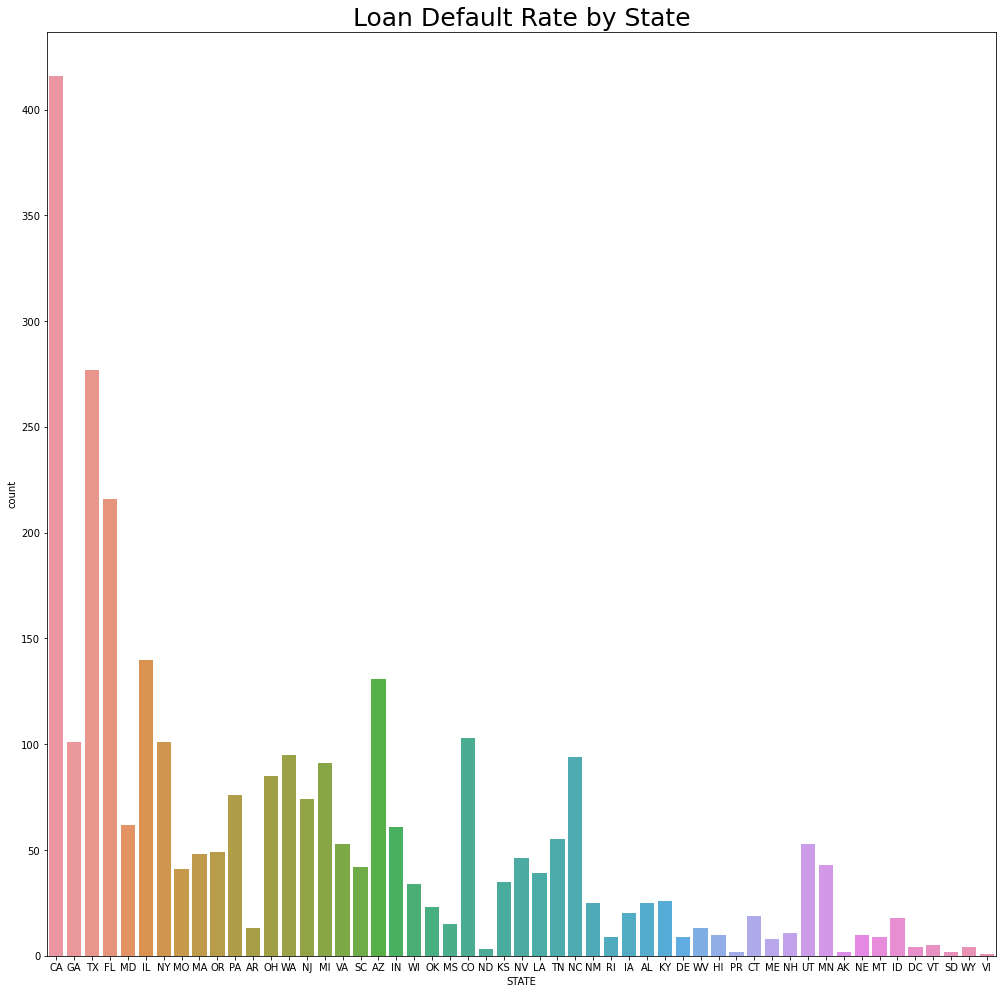

In [3]:
#Sorting default loans by state
df_state=df.drop(['LOAN_ID','ORIG_INT_R','ORIG_AMT','ORIG_TRM','LTV','CLTV','DEBT_TO_INCOME','CREDIT_SCORE','INSURANCE','LAST_UPB','MONTHS_TO_MATURITY','MSA','DELINQUENCY','LOAN_STATUS'], axis=1)
df_default=df_state[df_state['STATUS']=="DEFAULT"]
df_default
plt.figure(figsize=(17,17))
ax = sns.countplot(x="STATE", data=df_default).set_title('Loan Default Rate by State',fontsize=25)

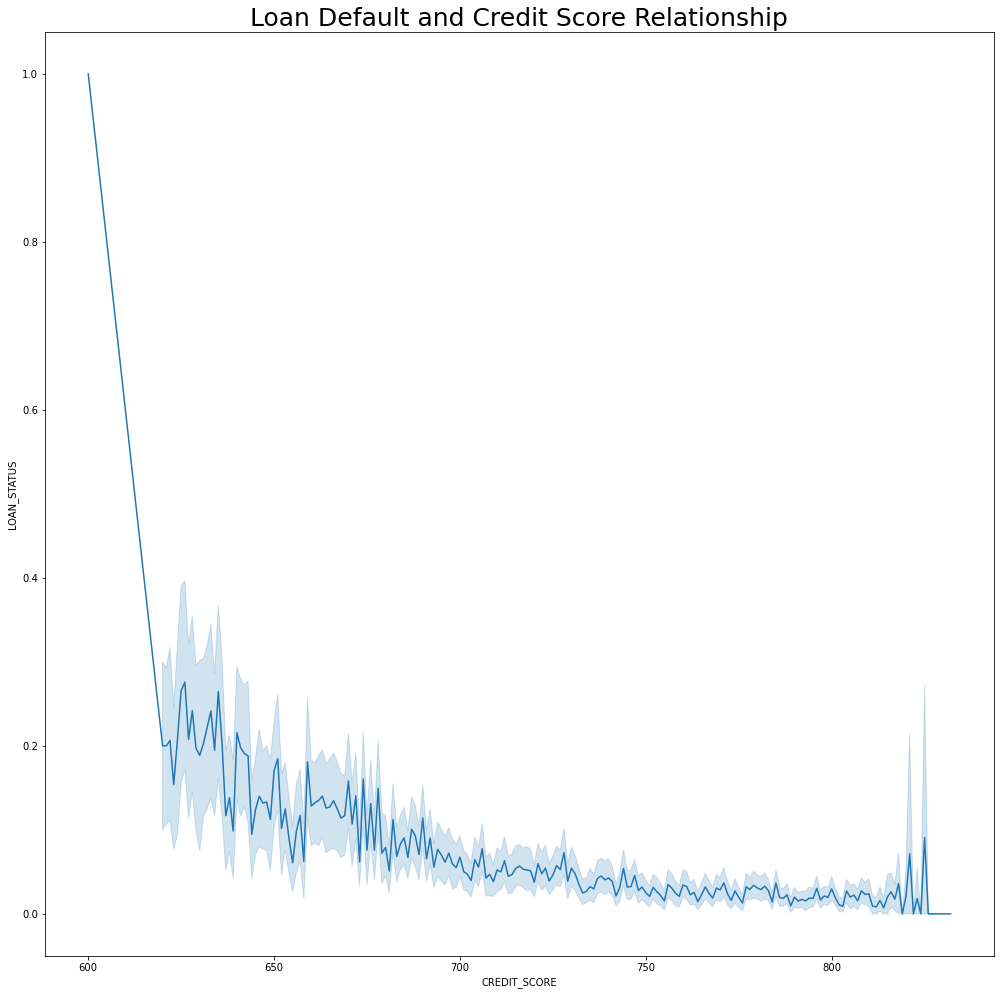

In [4]:
#Relationship between Defaulted Loans & Corresponding Credit Scores
df_credit_score=df.drop(['LOAN_ID','ORIG_INT_R','ORIG_AMT','ORIG_TRM','LTV','CLTV','DEBT_TO_INCOME','STATE','INSURANCE','LAST_UPB','MONTHS_TO_MATURITY','MSA','DELINQUENCY','STATUS'], axis=1)
plt.figure(figsize=(17,17))
ax = sns.lineplot(x="CREDIT_SCORE", y="LOAN_STATUS", data=df_credit_score).set_title('Loan Default and Credit Score Relationship',fontsize=25)

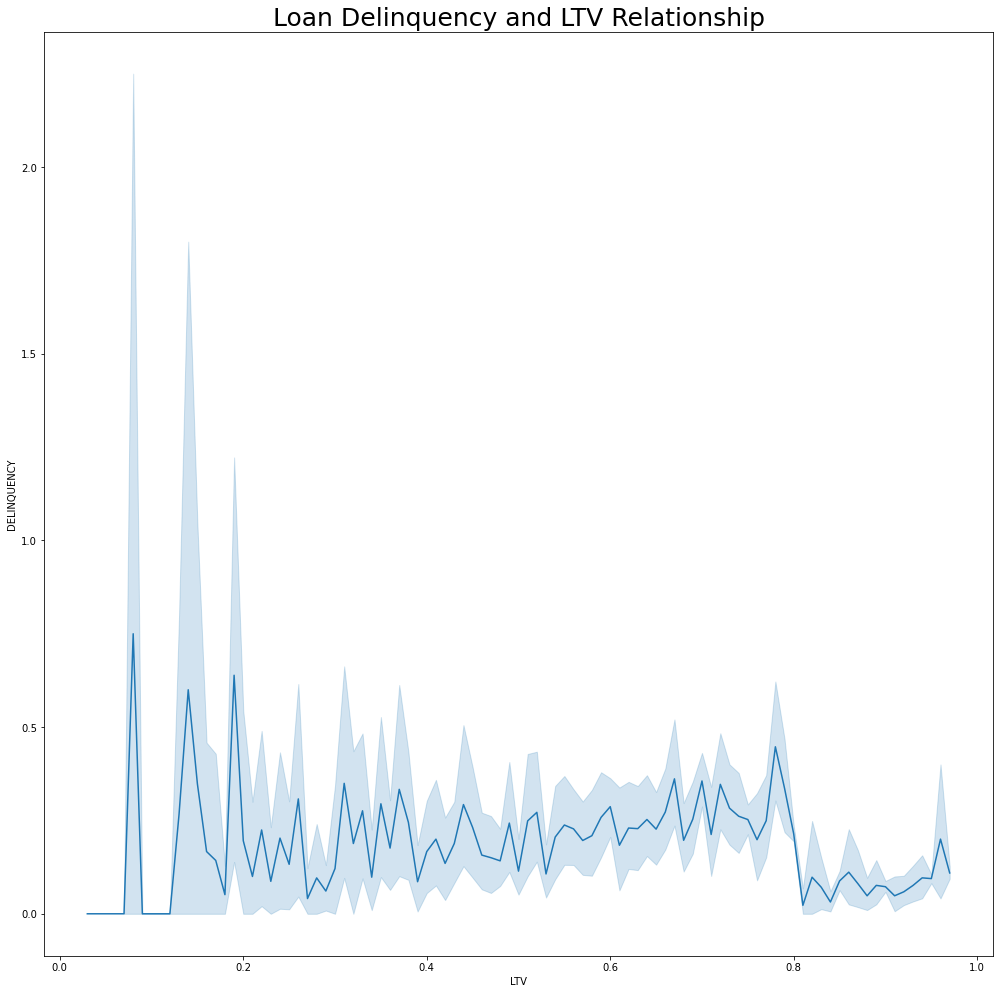

In [5]:
#Loan Delinquency & LTV Relationship
df_ltv=df.drop(['LOAN_ID','ORIG_INT_R','ORIG_AMT','ORIG_TRM','CREDIT_SCORE','CLTV','DEBT_TO_INCOME','STATE','INSURANCE','LAST_UPB','MONTHS_TO_MATURITY','MSA','LOAN_STATUS','STATUS'], axis=1)
plt.figure(figsize=(17,17))
ax = sns.lineplot(x="LTV", y="DELINQUENCY", data=df_ltv).set_title('Loan Delinquency and LTV Relationship',fontsize=25)

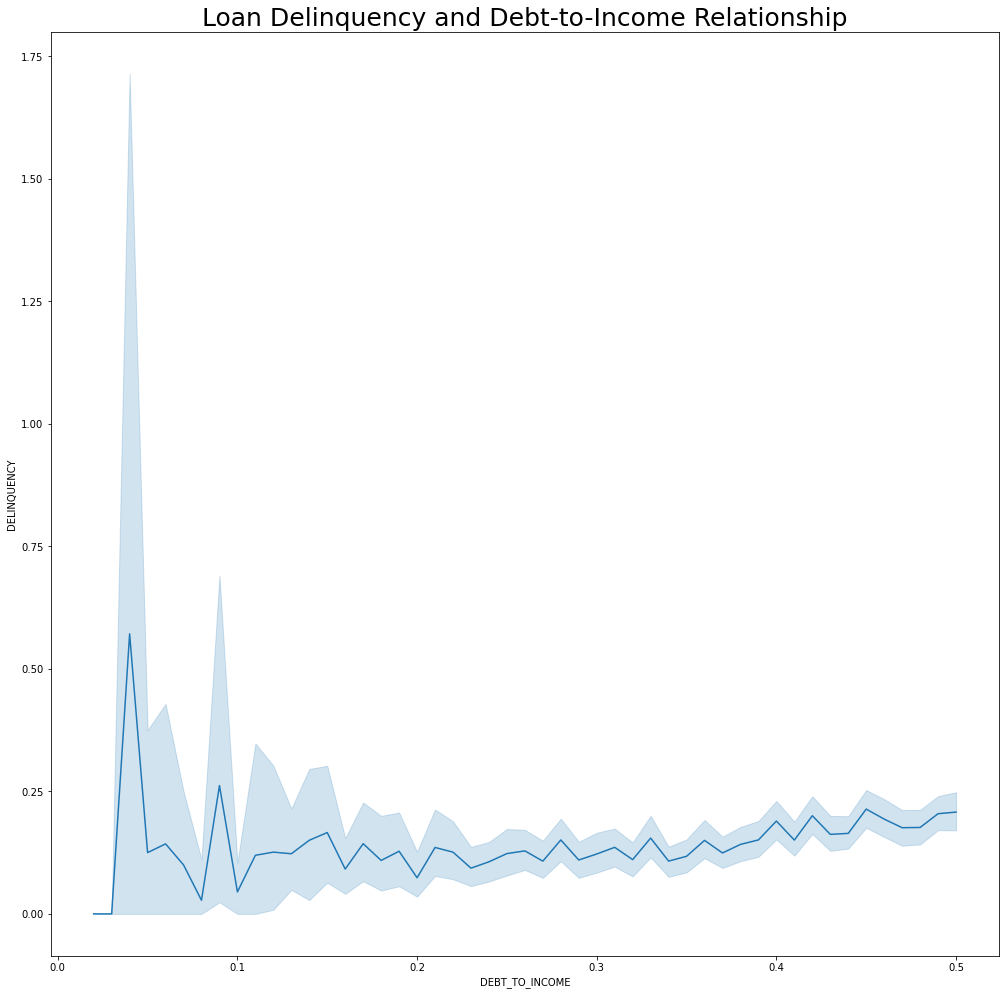

In [6]:
#Loan Delinquency & Debt-to-Income Relationship
df_dti=df.drop(['LOAN_ID','ORIG_INT_R','ORIG_AMT','ORIG_TRM','CREDIT_SCORE','CLTV','LTV','STATE','INSURANCE','LAST_UPB','MONTHS_TO_MATURITY','MSA','LOAN_STATUS','STATUS'], axis=1)
plt.figure(figsize=(17,17))
ax = sns.lineplot(x="DEBT_TO_INCOME", y="DELINQUENCY", data=df_dti).set_title('Loan Delinquency and Debt-to-Income Relationship',fontsize=25)

/Users/CamillaSabitova/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/CamillaSabitova/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/CamillaSabitova/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

,count,mean,std,min,25%,50%,75%,max
STATUS,,,,,,,,
CURRENT,60155.0,0.372065,0.091339,0.02,0.31,0.39,0.45,0.5
DEFAULT,2947.0,0.385782,0.090803,0.04,0.33,0.41,0.46,0.5


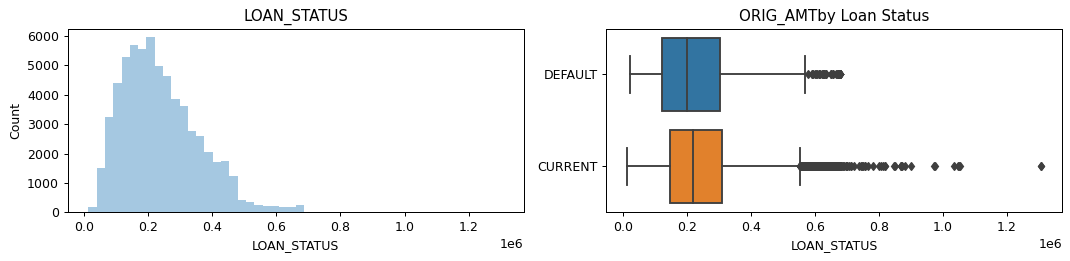

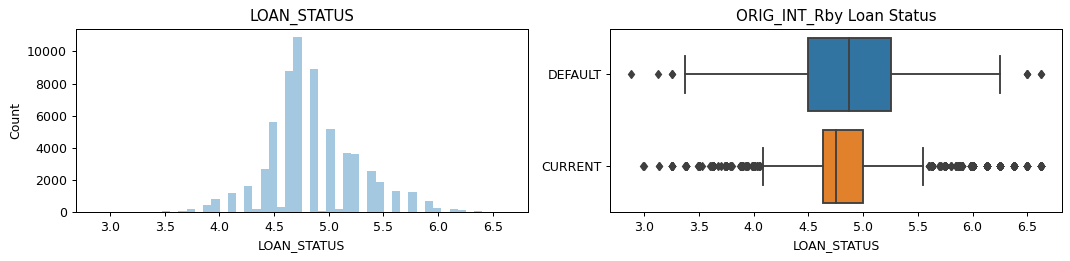

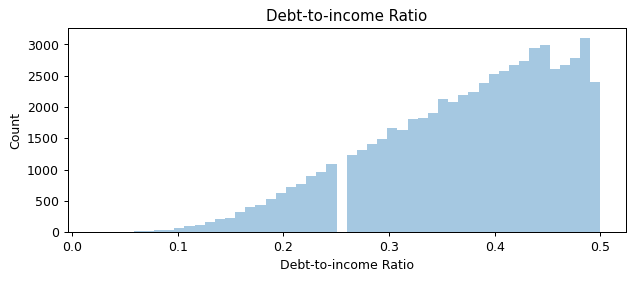

In [7]:
def plot_var(col_name, full_name, continuous):
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    

    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y="STATUS", data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + 'by Loan Status')
    else:
        charge_off_rates = df.groupby(col_name)['STATUS'].value_counts(normalize=True).loc[:,'DEFAULT']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

df['ORIG_AMT'].describe().apply(lambda x: format(x, 'f'))

plot_var('ORIG_AMT', 'LOAN_STATUS', continuous=True)

df.groupby('LOAN_STATUS')['ORIG_AMT'].describe()

df['ORIG_INT_R'].describe()
plot_var('ORIG_INT_R', 'LOAN_STATUS', continuous=True)

plt.figure(figsize=(8,3), dpi=90)
sns.distplot(df.loc[df['DEBT_TO_INCOME'].notnull() & (df['DEBT_TO_INCOME']<60), 'DEBT_TO_INCOME'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')
df.groupby('STATUS')['DEBT_TO_INCOME'].describe()

In [9]:
from sklearn.preprocessing import LabelEncoder
data=df.drop(['STATE', "STATUS"], axis=1)
le = LabelEncoder ()
x=data.iloc[:,:-1].values
y = le. fit_transform ( data.iloc[:,-1].values.ravel())
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.2, random_state=42)

In [10]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

In [11]:
import itertools
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix
get_ipython().run_line_magic('matplotlib', 'inline')
def plot_confusion_matrix(model, normalize=False): 
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",va="center",
                 color="black" if cm[i, j] > thresh else "black", fontsize=15)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
features = ['ORIG_INT_R','ORIG_AMT','ORIG_TRM',"LTV", "CLTV","DEBT_TO_INCOME","CREDIT_SCORE","INSURANCE","LAST_UPB","MONTHS_TO_MATURITY","DELINQUENCY","LOAN_STATUS"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data = data[features]
print(X_train.shape)
print(data.shape)

(50481, 11)
(63102, 12)


In [13]:
#Random Forest
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='entropy', random_state=0)
maxFeatures = range(1,data.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
le = LabelEncoder ()
X=data.iloc[:,:-1].values
y = le.fit_transform (data.iloc[:,-1].values.ravel())
rand.fit(X,y)
mean_scores=pd.DataFrame(rand.cv_results_)
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(criterion='entropy', max_features=2, random_state=0)


In [14]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "entropy",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1]
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

1.0


findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


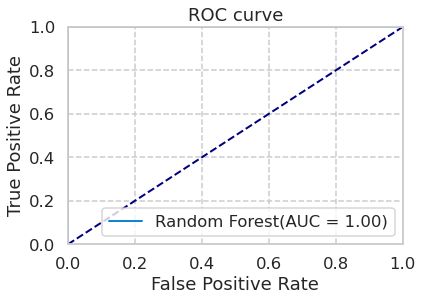

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


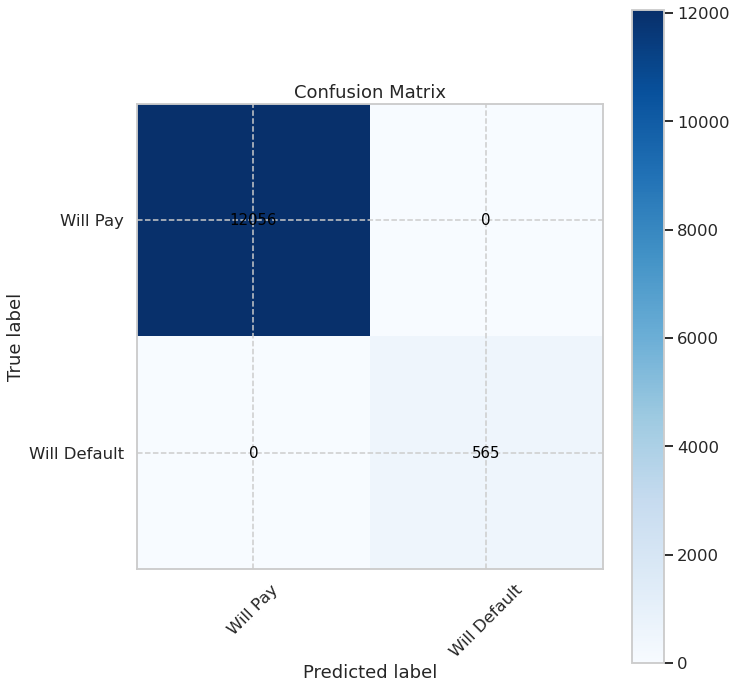

In [15]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(10,10))
plot_confusion_matrix(rfPredict)
plt.show()

In [16]:
###LOGISTIC Regression:

In [17]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    X=data.iloc[:,:-1].values
    y=data.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = pd.DataFrame(grid.cv_results_)
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

/Users/CamillaSabitova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best accuracy is 0.9819022354498383
LogisticRegression(C=0.001, random_state=0)


/Users/CamillaSabitova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression accuracy is  0.9834402979161715


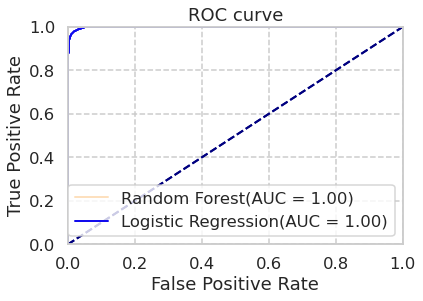

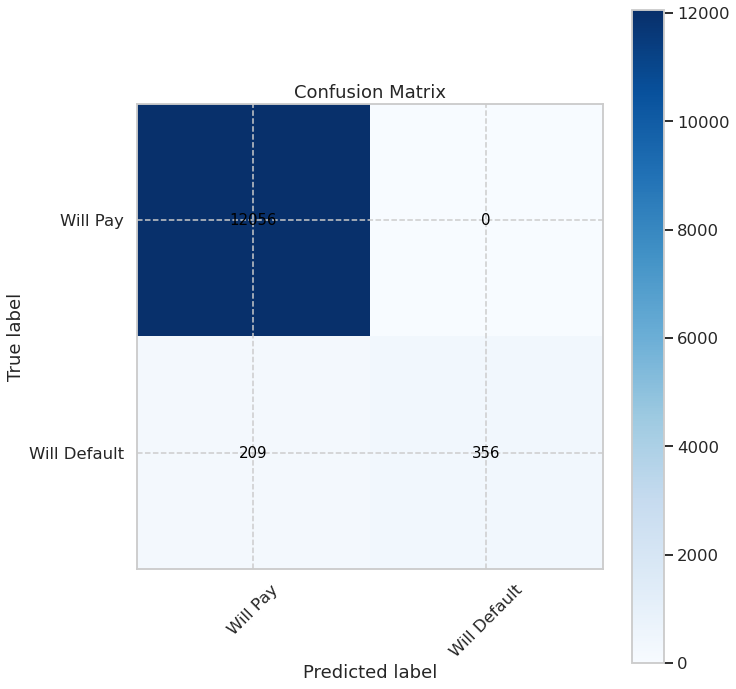

In [18]:
clf_LR = linear_model.LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(10,10))
plot_confusion_matrix(LR_Predict_bin)
plt.show()

In [19]:
#KNN
clf_knn = KNeighborsClassifier()
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data.iloc[:,:-1].values, data.iloc[:,-1].values)
grid_mean_scores = pd.DataFrame(grid.cv_results_)
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 8}
---------------
KNeighborsClassifier(n_neighbors=8)


 8
KNN accuracy is  0.9830441327945487


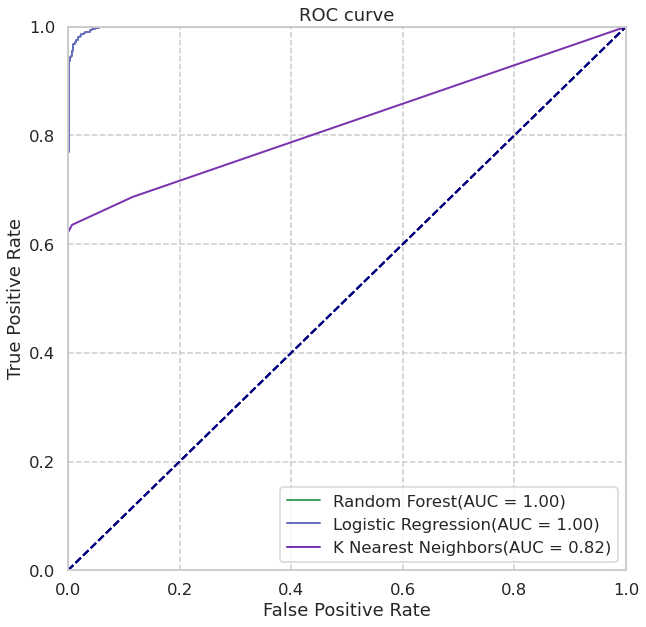

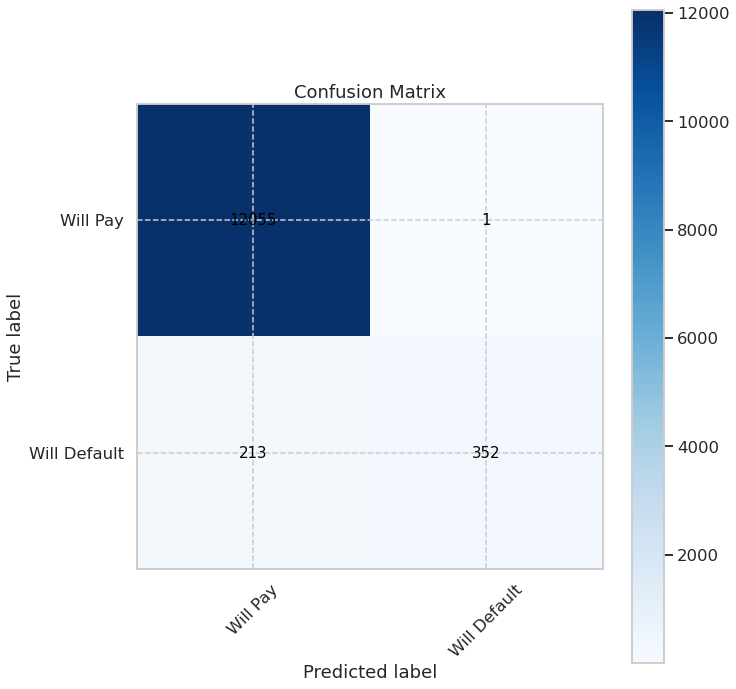

In [20]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plt.figure(figsize=(10,10))
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(10,10))
plot_confusion_matrix(knn_pred)
plt.show()

Best Criterion: entropy
Best max_depth: 12
Best Number Of Components: 11

DecisionTreeClassifier(criterion='entropy', max_depth=12)
Decision Tree accuracy is  1.0


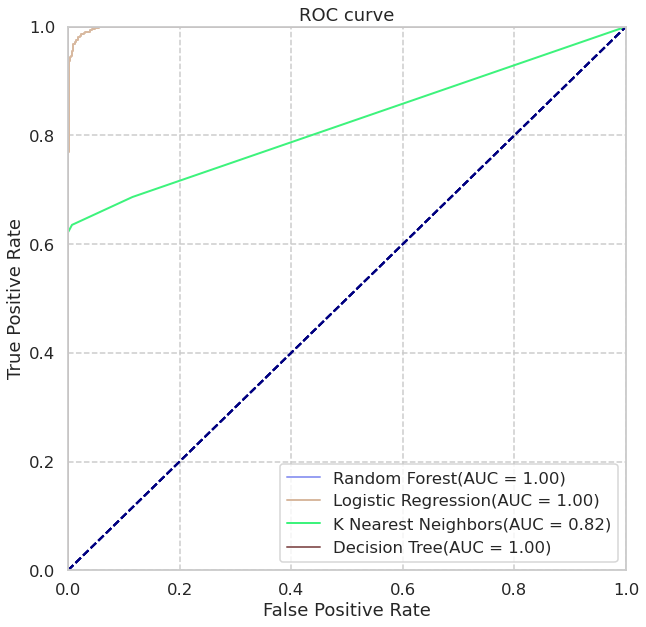

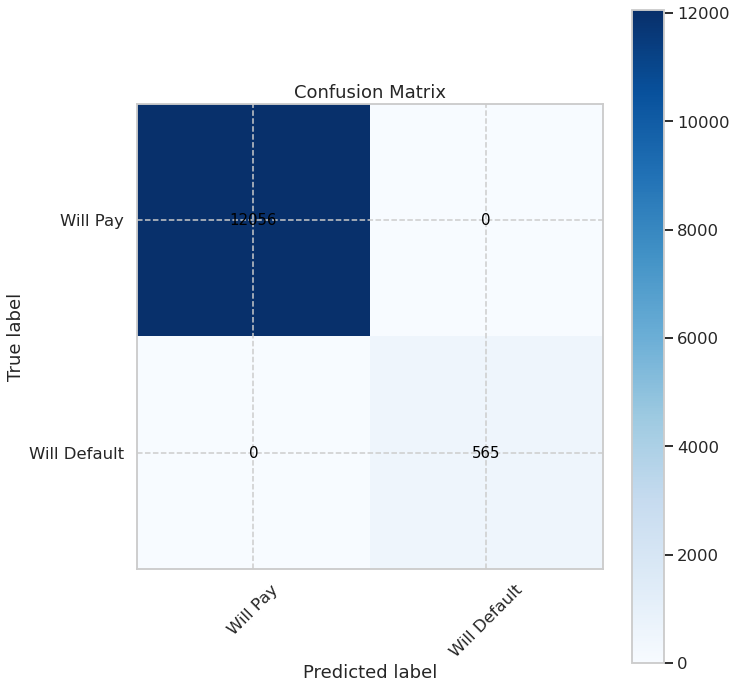

In [21]:
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
pca = decomposition.PCA()
decision_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('sc', sc), ('pca', pca), ('decisiontree', decision_tree)])
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]
parameters = dict(pca__n_components=n_components, decisiontree__criterion=criterion, decisiontree__max_depth=max_depth)

clf_tree = GridSearchCV(pipe, parameters)
clf_tree.fit(X, y)
print('Best Criterion:', clf_tree.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf_tree.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf_tree.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_tree.best_estimator_.get_params()['decisiontree'])



clf_tree_final = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       min_samples_leaf=1) 
clf_tree_final.fit(X_train,y_train)
tree_pred = clf_tree_final.predict(X_test)
tree_predictproba = clf_tree_final.predict_proba(X_test)[:,1]
tree_Acc = accuracy_score(y_test,tree_pred)
print("Decision Tree accuracy is ",tree_Acc)
plt.figure(figsize=(10,10))
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,tree_predictproba,'Decision Tree')
plt.show()
plt.figure(figsize=(10,10))
plot_confusion_matrix(tree_pred)
plt.show()

In [22]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("DT",classification_report(y_test, tree_pred, target_names=None))



RF               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12056
           1       1.00      1.00      1.00       565

    accuracy                           1.00     12621
   macro avg       1.00      1.00      1.00     12621
weighted avg       1.00      1.00      1.00     12621

LR               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12056
           1       1.00      0.63      0.77       565

    accuracy                           0.98     12621
   macro avg       0.99      0.82      0.88     12621
weighted avg       0.98      0.98      0.98     12621

KNN               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12056
           1       1.00      0.62      0.77       565

    accuracy                           0.98     12621
   macro avg       0.99      0.81      0.88     12621
weighted avg       0.98      0.98      0.98     12621

DT       

In [27]:
df=pd.read_csv("Fannie_Mae_Loans.csv")
df1=df.iloc[50482:63103]
df1.ORIG_AMT.sum()

class Mortgage:

    def __init__(self, P=0, yrs=30, CY=12, r=0.075, psa=1):
        self.psa = psa
        self.yrs = yrs
        self.CY = CY
        self.r = r
        self.n = yrs * CY
        self.pr = r / CY
        self.P = [P]
        self.int = [0]
        self.pmt = [0]
        self.prn = [0]
        self.pre = [0]
        self.totprn = [0]
        self.totcf =[0]
        if not isinstance(self, defaultCir):
            self.generate()
            self.generate_report()

    def calprn(self, BB, t):
        return BB * self.pr / (1 - (1 + self.pr) ** (self.n-t+1))

    def calint(self, BB):
        return BB * self.pr

    def calpre(self, t, BB):
        if t <= 30:
            cpr = t * 0.002 * self.psa
        else:
            cpr = 0.06 * self.psa
        return (1 - (1 - cpr)**(1/12))*(BB + self.calprn(BB, t))

    def generate(self):
        for t in range(1, self.n + 1):
            self.P.append(self.P[t-1] - self.prn[t-1] - self.pre[t-1])
            self.prn.append(- self.calprn(self.P[t], t))
            self.int.append(self.calint(self.P[t]))
            self.pmt.append(- self.calprn(self.P[t], t) + self.int[t])
            self.pre.append(self.calpre(t, self.P[t]))
            self.totprn.append(self.prn[t] + self.pre[t])
            self.totcf.append(self.int[t] + self.totprn[t])

    def getn(self):
        return self.n

    def gettotcf(self):
        return self.totcf

    def gettotprn(self):
        return self.totprn

    def getpre(self):
        return self.pre

    def getprn(self):
        return self.prn

    def getpmt(self):
        return self.pmt

    def getp(self):
        return self.P

    def getint(self):
        return self.int

    def getcy(self):
        return self.CY

    def getsmm(self, t):
        if t <= 30:
            cpr = t * 0.002 * self.psa
        else:
            cpr = 0.06 * self.psa
        return 1 - (1 - cpr) ** (1 / 12)

    def generate_report(self):
        with open('MortgageAnalysis.csv', 'w') as csvfile:
            csvfile.write(
                format("month", "<6s") + "," + format("years", "<15s") + "," 
                + format("Balance", "<15s") + "," 
                + format("Principal","<15s") + "," + format(
                    "Prepayment", "<15s") + "," + format("Default", "<15s") + "," 
                + format("Recovery", "<15s") + "," + format("Intmp", "<15s") + "," 
                + format("RcvIntDef", "<15s") + "," 
                + format("RcvPrnDef","<15s") + "," 
                + format("TotPrn","<7s") + "," 
                + format("TotInt","<7s") + "," + format("Totloss","<15s"))
            csvfile.write("\n")
            for i in range(self.n + 1):
                line = [i, i / self.CY, self.P[i], self.pmt[i], self.int[i], self.prn[i],
                        self.pre[i], self.totprn[i], self.totcf[i]]

                for j in range(len(line)):
                    csvfile.write(format(str(round(line[j], 2)), "<15s"))
                    if j < 8:
                        csvfile.write(',')
                csvfile.write("\n")

            csvfile.close()

class defaultCir(Mortgage):

    def __init__(self, P=0,  yrs=30, CY=12, r=0.075, psa=1, Rr=0.6, ADR=0.0448):
        super().__init__()
        self.P = [P]
        self.psa = psa
        self.yrs = yrs
        self.CY = CY
        self.r = r
        self.__Rr = Rr
        self.__ADR = ADR
        self.__default = [0]
        self.__recovery = [0]
        self.__intmp = [0]
        self.__rcvintdef = [0]
        self.__rcvprndef = [0]
        self.__totlossprn = [0]
        self.default_generate()
        self.generate_report()

    def caldefault(self, BB, Prn, Pre):
        return (1 - (1 - self.__ADR)**(1/12))*(BB - Prn - Pre)

    def calrecv(self, default):
        return self.__Rr * default

    def calrcvint(self, default):
        return self.pr * default

    def default_generate(self):
        for t in range(1, self.n + 1):
            self.P.append(self.P[t-1] - self.prn[t-1] - self.pre[t-1]- self.__default[t-1])
            self.prn.append(- self.calprn(self.P[t], t))
            self.pre.append(self.calpre(t, self.P[t]))
            self.__default.append(self.caldefault(self.P[t], self.prn[t], self.pre[t]))
            self.__recovery.append(self.calrecv(self.__default[t]))
            self.__intmp.append((self.P[t] - self.__default[t]) * self.pr)
            self.__rcvintdef.append(self.__default[t] * self.pr)
            self.__rcvprndef.append(self.__recovery[t] - self.__rcvintdef[t])
            self.totprn.append(self.prn[t] + self.pre[t]+self.__rcvprndef[t])
            self.int.append(self.__intmp[t] + self.__rcvintdef[t])
            self.__totlossprn.append(self.__rcvprndef[t] - self.__default[t])

    def generate_report(self):
        with open('MortgageAnalysis.csv', 'w') as csvfile:
            csvfile.write(
                format("month", "<5s") + "," + format("years", "<15s") + "," + format("Balance", "<15s") + "," 
                + format("Principal","<15s") + "," + format("Prepayment", "<15s") + "," 
                + format("Default", "<15s") + "," + format("Recovery", "<15s") + "," + format("Intmp", "<15s") + "," 
                + format("RcvIntDef", "<15s") + "," + format("RcvPrnDef","<15s") + "," 
                + format("TotPrn","<6s") + "," + format("TotInt","<6s") + "," + format("Totloss","<15s"))
            csvfile.write("\n")
            for i in range(self.n + 1):
                line = [i, i / self.CY, self.P[i], self.prn[i], self.pre[i], self.__default[i],
                        self.__recovery[i], self.__intmp[i], self.__rcvintdef[i], self.__rcvprndef[i], self.totprn[i], self.int[i], self.__totlossprn[i]]

                for j in range(len(line)):
                    csvfile.write(format(str(round(line[j], 2)), "<15s"))
                    if j < 12:
                        csvfile.write(',')
                csvfile.write("\n")

            csvfile.close()

    def getdefault(self):
        return self.__default

    def getrecovery(self):
        return self.__recovery

    def getintmp(self):
        return self.__intmp

    def getrcvint(self):
        return self.__rcvintdef

    def getrcvprn(self):
        return self.__rcvprndef

    def totloss(self):
        return self.__totlossprn

test = defaultCir(P=3115277000,  yrs=30, CY=12, r=0.075, psa=1, Rr=0, ADR=0.0448)


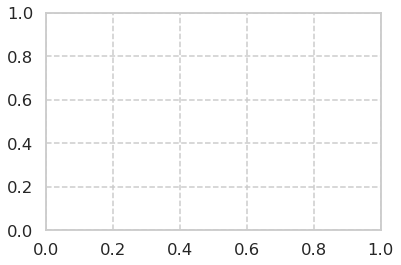

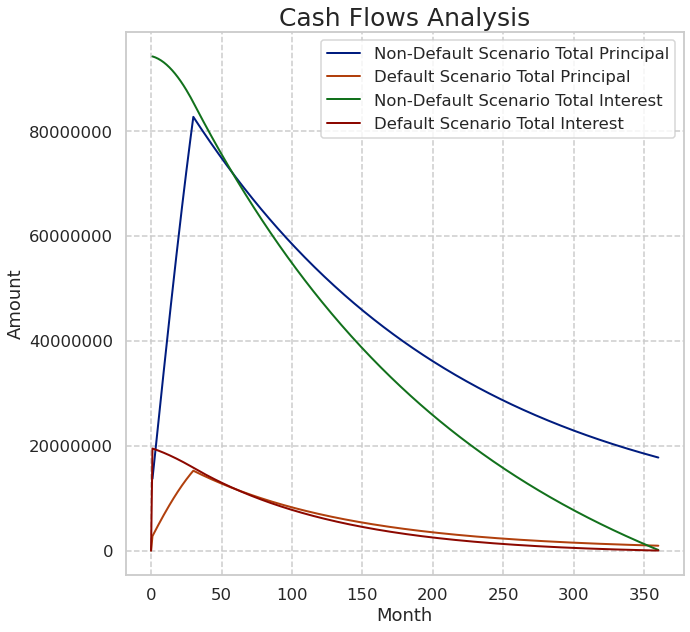

410937879.44

In [28]:
df1=pd.read_csv("MortgageAnalysis_Non_Default.csv")
df2=pd.read_csv("MortgageAnalysis.csv")

fig, ax = plt.subplots()
plt.figure(figsize=(10,10))
plt.ticklabel_format(useOffset=False, style='plain')
x1=df1.month
y1=df1.TotPrn
x2=df2.month
y2=df2.TotPrn
x3=df1.month
y3=df1.TotInt
x4=df2.month
y4=df2.TotInt
plt.plot(x1,y1, label='Non-Default Scenario Total Principal')
plt.plot(x2,y2, label='Default Scenario Total Principal')
plt.plot(x3,y3, label='Non-Default Scenario Total Interest')
plt.plot(x4,y4, label='Default Scenario Total Interest')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.title("Cash Flows Analysis", fontsize=25)
plt.legend()
plt.show()

###Present Value of Cash Flow Calculation
cf_non_default=pd.read_csv("MortgageAnalysis_Non_Default.csv")
r=0.00625  ###periodic monthly 7.5% interest rate is 0.0625%
cf_non_default['pv']=(cf_non_default['TotPrn']+cf_non_default['TotInt'])/(1+r)**360
npv=cf_non_default['pv'].sum()
round(npv,2)

cf_default=pd.read_csv("MortgageAnalysis.csv")
r=0.00625  ###periodic monthly 7.5% interest rate is 0.0625%
cf_default['pv']=(cf_default['TotPrn']+cf_default['TotInt'])/(1+r)**360
npv_default=cf_default['pv'].sum()
round(npv_default,2)

